### [1] 패키지 불러오기

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image

### [2] Data transform 정의

In [ ]:
import torchvision.transforms as transforms

# 이미지 전처리
size = [230, 230]
center_size = [224, 224]

TrainTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ValidTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### [3] 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### [4] MultimodalEyeDataset 클래스 + thickness

In [ ]:
# CIMT thickness를 5개 구간으로 분류하는 함수
def thickness_to_label(thickness):
    if thickness < 0.7:
        return 0
    elif thickness < 0.9:
        return 1
    elif thickness < 1.1:
        return 2
    elif thickness < 1.3:
        return 3
    else:
        return 4

In [ ]:
class MultimodalEyeDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.data = data
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        left_img = Image.open(os.path.join(self.image_path, item['left_eye'])).convert('RGB')
        right_img = Image.open(os.path.join(self.image_path, item['right_eye'])).convert('RGB')

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        label = torch.tensor(item['label'], dtype=torch.long)

        # 임상정보
        norm_age = torch.tensor(item['age'], dtype=torch.float32)
        gender = item['gender']
        gender_onehot = torch.tensor([1, 0] if gender == 0 else [0, 1], dtype=torch.float32)
        clinical = torch.cat([norm_age.unsqueeze(0), gender_onehot])  # shape: [3]

        # thickness_class (이미 전처리된 정수 0~4)
        thick_class = torch.tensor(item['thickness_class'], dtype=torch.long)

        return left_img, right_img, clinical, label, thick_class



    @classmethod
    def from_json(cls, json_file, image_path, group_value=1, include_0_9mm=True, transform=None):
      with open(json_file, 'r') as f:
        raw_data = json.load(f)

      usable_data = [
          item for item in raw_data.values()
          if item['group'] == group_value and (include_0_9mm or item['thickness'] != 0.9)
      ]

      # 두께 값 추출
      thicknesses = [item['thickness'] for item in usable_data]
      min_t, max_t = min(thicknesses), max(thicknesses)

      # 5개 구간으로 나눠 thickness_class 추가
      for item in usable_data:
          t = item['thickness']
          bin_idx = min(int((t - min_t) / (max_t - min_t) * 5), 4)  # 0~4
          item['thickness_class'] = bin_idx

      print(f"usable samples for group {group_value}: {len(usable_data)}")
      return cls(usable_data, image_path, transform)


### [5] train_loader, val_loader, test_loader 구성

In [ ]:
# 경로 설정
json_file = '/content/drive/MyDrive/cv_project/dataset/data_info.json'
image_path = '/content/drive/MyDrive/cv_project/dataset/train_images/Fundus_CIMT_2903 Dataset'

# 학습용 데이터셋 (group 1)
train_dataset = MultimodalEyeDataset.from_json(
    json_file=json_file,
    image_path=image_path,
    group_value=1,
    include_0_9mm=True,
    transform=TrainTransform
)

# 검증용 데이터셋 (group 2)
val_dataset = MultimodalEyeDataset.from_json(
    json_file=json_file,
    image_path=image_path,
    group_value=2,
    include_0_9mm=True,
    transform=ValidTransform
)

# 테스트용 데이터셋 (group 3)
test_dataset = MultimodalEyeDataset.from_json(
    json_file=json_file,
    image_path=image_path,
    group_value=3,
    include_0_9mm=True,
    transform=ValidTransform
)

from torch.utils.data import DataLoader

# 최적화 설정: num_workers=2, pin_memory=True
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


usable samples for group 1: 2603
usable samples for group 2: 200
usable samples for group 3: 100


### [6] Multimodal 모델 클래스 정의

In [ ]:
import torch
import torch.nn as nn
import timm

class MultimodalModel(nn.Module):
    def __init__(self, dropout_p=0.3):
        super(MultimodalModel, self).__init__()
        self.backbone = timm.create_model('seresnext50_32x4d.racm_in1k', pretrained=True, num_classes=0)
        self.dropout = nn.Dropout(dropout_p)

        # 임상정보 임베딩 (3차원 → 128차원)
        self.clinical_fc = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )

        # 분류 헤드 (4096+128 → 2)
        self.classifier = nn.Sequential(
            nn.Linear(4096 + 128, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 2)
        )

        # 두께 구간 분류 헤드 (4096+128 → 5개 클래스)
        self.thick_classifier = nn.Sequential(
            nn.Linear(4096 + 128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, 5)
        )

    def forward(self, left, right, clinical):
        left_feat = self.backbone(left)
        right_feat = self.backbone(right)
        image_feat = torch.cat([left_feat, right_feat], dim=1)  # shape: (B, 4096)
        image_feat = self.dropout(image_feat)

        clinical_feat = self.clinical_fc(clinical)  # shape: (B, 128)

        fused = torch.cat([image_feat, clinical_feat], dim=1)  # shape: (B, 4224)

        class_out = self.classifier(fused)
        thick_out = self.thick_classifier(fused)

        return class_out, thick_out


### [7] FocalLoss 클래스 정의

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


### [8] 학습 루프

In [ ]:
import torch.nn.functional as F
from torch import nn
import json

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 손실 함수 정의
criterion_cls = FocalLoss()
criterion_thick_cls = nn.CrossEntropyLoss()
lambda_thick = 1.0  # 두께 구간 분류 손실의 가중치

# 모델 초기화
model = MultimodalModel().to(device)

# 옵티마이저 및 스케줄러
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 학습 설정
epochs = 20
best_val_loss = float('inf')

# 손실 기록 리스트
train_cls_losses, train_thick_losses, train_total_losses = [], [], []
val_cls_losses, val_thick_losses, val_total_losses = [], [], []

# 학습 루프
for epoch in range(epochs):
    model.train()
    running_cls_loss, running_thick_loss, running_total_loss = 0.0, 0.0, 0.0

    for left, right, clinical, labels, thickness_classes in train_loader:
        left, right, clinical = left.to(device), right.to(device), clinical.to(device)
        labels = labels.to(device)
        thickness_classes = thickness_classes.to(device)

        outputs_cls, outputs_thick = model(left, right, clinical)

        loss_cls = criterion_cls(outputs_cls, labels)
        loss_thick = criterion_thick_cls(outputs_thick, thickness_classes)
        loss = loss_cls + lambda_thick * loss_thick

        loss.backward()
        optimizer.step()

        running_cls_loss += loss_cls.item()
        running_thick_loss += loss_thick.item()
        running_total_loss += loss.item()

    avg_train_cls = running_cls_loss / len(train_loader)
    avg_train_thick = running_thick_loss / len(train_loader)
    avg_train_total = running_total_loss / len(train_loader)

    train_cls_losses.append(avg_train_cls)
    train_thick_losses.append(avg_train_thick)
    train_total_losses.append(avg_train_total)

    # Validation
    model.eval()
    val_cls_loss, val_thick_loss, val_total_loss = 0.0, 0.0, 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for left, right, clinical, labels, thickness_classes in val_loader:
            left, right = left.to(device), right.to(device)
            clinical = clinical.to(device)
            labels = labels.to(device)
            thickness_classes = thickness_classes.to(device)

            outputs_cls, outputs_thick = model(left, right, clinical)

            loss_cls = criterion_cls(outputs_cls, labels)
            loss_thick = criterion_thick_cls(outputs_thick, thickness_classes)
            loss = loss_cls + lambda_thick * loss_thick

            val_cls_loss += loss_cls.item()
            val_thick_loss += loss_thick.item()
            val_total_loss += loss.item()

            preds = torch.argmax(outputs_cls, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_cls = val_cls_loss / len(val_loader)
    avg_val_thick = val_thick_loss / len(val_loader)
    avg_val_total = val_total_loss / len(val_loader)
    val_accuracy = correct / total

    val_cls_losses.append(avg_val_cls)
    val_thick_losses.append(avg_val_thick)
    val_total_losses.append(avg_val_total)

    scheduler.step()

    # Best 모델 저장
    if avg_val_total < best_val_loss:
        best_val_loss = avg_val_total
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv_project/02multimodal/best_multimodal_multitask_cls2_1e-3.pth')
        print(f"Best model updated at epoch {epoch+1} (Val Total Loss: {best_val_loss:.4f})")

    # 로그 출력
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train: [Cls: {avg_train_cls:.4f} | Thick: {avg_train_thick:.4f} | Total: {avg_train_total:.4f}] "
          f"| Val: [Cls: {avg_val_cls:.4f} | Thick: {avg_val_thick:.4f} | Total: {avg_val_total:.4f}] "
          f"| Val Acc: {val_accuracy:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")


Best model updated at epoch 1 (Val Total Loss: 2.9849)
Epoch 1/20 | Train: [Cls: 0.1833 | Thick: 1.2107 | Total: 1.3940] | Val: [Cls: 0.8126 | Thick: 2.1723 | Total: 2.9849] | Val Acc: 0.5050 | LR: 0.001000
Best model updated at epoch 2 (Val Total Loss: 1.7488)
Epoch 2/20 | Train: [Cls: 0.1437 | Thick: 1.1459 | Total: 1.2896] | Val: [Cls: 0.2257 | Thick: 1.5231 | Total: 1.7488] | Val Acc: 0.5200 | LR: 0.001000
Epoch 3/20 | Train: [Cls: 0.1456 | Thick: 1.1192 | Total: 1.2648] | Val: [Cls: 0.1764 | Thick: 2.0371 | Total: 2.2135] | Val Acc: 0.6000 | LR: 0.001000
Epoch 4/20 | Train: [Cls: 0.1650 | Thick: 1.1047 | Total: 1.2697] | Val: [Cls: 0.1803 | Thick: 1.8216 | Total: 2.0019] | Val Acc: 0.5150 | LR: 0.001000
Epoch 5/20 | Train: [Cls: 0.1504 | Thick: 1.1522 | Total: 1.3026] | Val: [Cls: 0.1916 | Thick: 1.8157 | Total: 2.0073] | Val Acc: 0.5000 | LR: 0.001000
Epoch 6/20 | Train: [Cls: 0.4319 | Thick: 2.0252 | Total: 2.4570] | Val: [Cls: 0.1886 | Thick: 1.9180 | Total: 2.1066] | Val Acc: 

### [9] 손실 json 파일 저장

In [ ]:
import json

# 저장할 딕셔너리 생성 (reg → thick 로 수정)
loss_history = {
    "train_cls_loss": train_cls_losses,
    "train_thick_loss": train_thick_losses,
    "train_total_loss": train_total_losses,
    "val_cls_loss": val_cls_losses,
    "val_thick_loss": val_thick_losses,
    "val_total_loss": val_total_losses
}

# 저장 경로 설정
save_path = "/content/drive/MyDrive/cv_project/02multimodal/loss_history_multitask_cls2_1e-3.json"

# JSON 저장
with open(save_path, "w") as f:
    json.dump(loss_history, f, indent=2)

print(f"loss_history_multitask_cls2_1e-3.json 저장 완료: {save_path}")


loss_history_multitask_cls2_1e-3.json 저장 완료: /content/drive/MyDrive/cv_project/02multimodal/loss_history_multitask_cls2_1e-3.json


### [10] loss 그래프

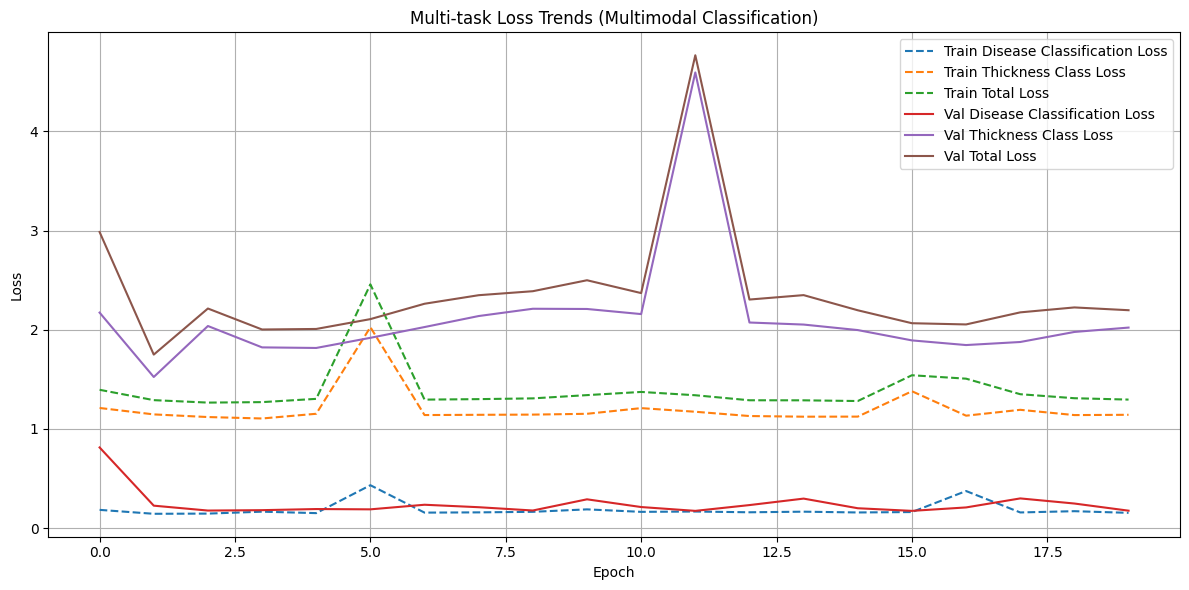

In [ ]:
import json
import matplotlib.pyplot as plt

# JSON 파일 경로 (멀티모달 - 두께 분류 기준)
load_path = '/content/drive/MyDrive/cv_project/02multimodal/loss_history_multitask_cls2_1e-3.json'

# JSON 불러오기
with open(load_path, 'r') as f:
    loss_history = json.load(f)

# 리스트 추출 (reg → thick)
train_cls_losses = loss_history['train_cls_loss']
train_thick_losses = loss_history['train_thick_loss']
train_total_losses = loss_history['train_total_loss']
val_cls_losses = loss_history['val_cls_loss']
val_thick_losses = loss_history['val_thick_loss']
val_total_losses = loss_history['val_total_loss']

# 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_cls_losses, label='Train Disease Classification Loss', linestyle='--')
plt.plot(train_thick_losses, label='Train Thickness Class Loss', linestyle='--')
plt.plot(train_total_losses, label='Train Total Loss', linestyle='--')

plt.plot(val_cls_losses, label='Val Disease Classification Loss')
plt.plot(val_thick_losses, label='Val Thickness Class Loss')
plt.plot(val_total_losses, label='Val Total Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi-task Loss Trends (Multimodal Classification)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### [11] 예측 수행

In [ ]:
import torch
from tqdm import tqdm
import json

# 모델 로드
model = MultimodalModel().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cv_project/02multimodal/best_multimodal_multitask_cls2_1e-3.pth'))
model.eval()

# 예측 결과 저장 리스트
results = []

with torch.no_grad():
    for left, right, clinical, labels, thickness_classes in tqdm(test_loader, desc="Predicting"):
        left = left.to(device)
        right = right.to(device)
        clinical = clinical.to(device)

        # 예측 (disease + thickness class)
        outputs_cls, outputs_thick = model(left, right, clinical)

        # disease 예측
        probs_cls = torch.softmax(outputs_cls, dim=1)
        preds_cls = torch.argmax(probs_cls, dim=1)

        # thickness class 예측
        probs_thick = torch.softmax(outputs_thick, dim=1)
        preds_thick = torch.argmax(probs_thick, dim=1)

        for t_label, p_label, prob_d, t_thick, p_thick in zip(
            labels.cpu(), preds_cls.cpu(), probs_cls[:, 1].cpu(),
            thickness_classes.cpu(), preds_thick.cpu()
        ):
            results.append({
                "true_label": int(t_label.item()),
                "pred_label": int(p_label.item()),
                "prob_thickened": float(prob_d.item()),  # thickened 클래스 확률
                "true_thickness_class": int(t_thick.item()),
                "pred_thickness_class": int(p_thick.item())
            })

# 저장
output_path = "/content/drive/MyDrive/cv_project/02multimodal/predict_result_multitask_cls2_1e-3.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"예측 결과 저장 완료: {output_path}")


Predicting: 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

예측 결과 저장 완료: /content/drive/MyDrive/cv_project/02multimodal/predict_result_multitask_cls2_1e-3.json


### [12] 평가

[Disease Classification Evaluation]
정확도 (Accuracy): 0.5000
AUC-ROC: 0.5400

분류 리포트:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        50
   Thickened       0.50      1.00      0.67        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100

Confusion Matrix:
[[ 0 50]
 [ 0 50]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


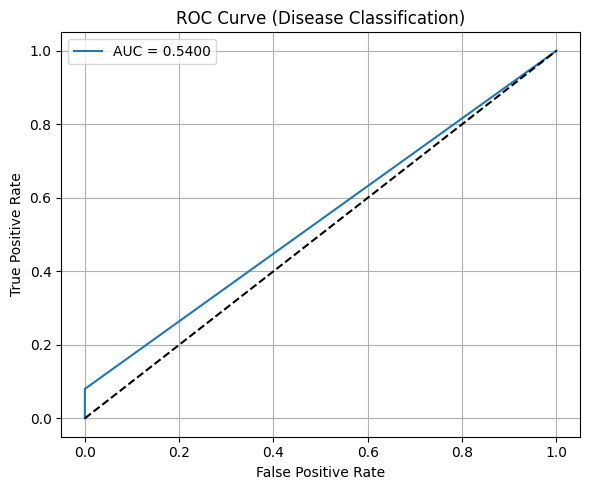


[Thickness Class Classification Evaluation]
정확도 (Accuracy): 0.3800
분류 리포트:
              precision    recall  f1-score   support

           0       1.00      0.17      0.29        18
           1       0.55      0.56      0.55        32
           2       0.27      0.85      0.40        20
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00         4

    accuracy                           0.38       100
   macro avg       0.36      0.32      0.25       100
weighted avg       0.41      0.38      0.31       100

Confusion Matrix:
[[ 3 11  4  0  0]
 [ 0 18 14  0  0]
 [ 0  3 17  0  0]
 [ 0  1 25  0  0]
 [ 0  0  4  0  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import json
import numpy as np
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt

# 예측 결과 불러오기
with open("/content/drive/MyDrive/cv_project/02multimodal/predict_result_multitask_cls2_1e-3.json", "r") as f:
    results = json.load(f)

# 1. 질병 분류 관련
y_true_cls = [r["true_label"] for r in results]
y_pred_cls = [r["pred_label"] for r in results]
y_prob_cls = [r["prob_thickened"] for r in results]

# 2. 두께 구간 분류 관련
y_true_thick = [r["true_thickness_class"] for r in results]
y_pred_thick = [r["pred_thickness_class"] for r in results]

# === [1] 질병 분류 평가 ===
fpr, tpr, _ = roc_curve(y_true_cls, y_prob_cls)
auc_score = roc_auc_score(y_true_cls, y_prob_cls)
accuracy = np.mean(np.array(y_true_cls) == np.array(y_pred_cls))

print("[Disease Classification Evaluation]")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("\n분류 리포트:")
print(classification_report(y_true_cls, y_pred_cls, target_names=["Normal", "Thickened"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true_cls, y_pred_cls))

# === ROC Curve 시각화 ===
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Disease Classification)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === [2] 두께 구간 분류 평가 ===
print("\n[Thickness Class Classification Evaluation]")
thick_accuracy = np.mean(np.array(y_true_thick) == np.array(y_pred_thick))
print(f"정확도 (Accuracy): {thick_accuracy:.4f}")
print("분류 리포트:")
print(classification_report(y_true_thick, y_pred_thick))
print("Confusion Matrix:")
print(confusion_matrix(y_true_thick, y_pred_thick))
